# Transformación de Audio en Imagen de Espectrograma
---
### Configuración General del Entorno de Trabajo

Esta sección detecta si el notebook está corriendo en un entorno COLAB o en uno LOCAL . Monta la carpeta de Google Drive si corresponde y define constantes para trabajar de forma general con cualquir script. Modificar las definiciones de las carpetas según el entorno y configuración del mismo.

In [5]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    LOCAL_DIR = './DATOS/'  # carpeta local en maquina virtual
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../DATOS/' # carpeta donde se encuentran los datasets
    LOCAL_DIR = DATOS_DIR

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Preparación de Datos
Descomprime el zip desde g-Drive en una carpeta local

In [6]:
import zipfile
import os

# Ruta al archivo ZIP en Google Drive
zip_path = os.path.join(DATOS_DIR, 'Voz-Palabras.zip')

# Ruta de destino para la extracción (carpeta local)
extract_dir = LOCAL_DIR

# Verificar si el archivo ZIP existe
if not os.path.exists(zip_path):
    print(f"Error: El archivo {zip_path} no existe.")
else:
    # Crear la carpeta de destino si no existe
    os.makedirs(extract_dir, exist_ok=True)

    # Descomprimir el archivo ZIP
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Archivo descomprimido exitosamente en: {extract_dir}")
    except zipfile.BadZipFile:
        print("Error: El archivo ZIP está corrupto o no es válido.")
    except Exception as e:
        print(f"Ocurrió un error al descomprimir: {str(e)}")

Archivo descomprimido exitosamente en: ./DATOS/


---
### Recupera el Listado de Archivos de Voz
Recupera listado de archivos desde el disco y obtiene su clase a partir del nombre


In [7]:
# Instalar los siguientes paquetes para poder correr ejecutar las funciones de este módulo
import audio as ta
#conda install librosa
#conda install ffmpeg
#conda install audioread

import librosa
import  glob
import matplotlib.pyplot as plt
from IPython.display import Audio


def extraer_nombre_archivo(filename):
    # formato esperado :voz\\013F96_M_CERO.ogg
    idx = filename.rfind('_') # busca el "_" comenzando desde atras

    return filename[idx+1:-4]


IMG_ERROR = 'No hay imagenes para cargar. Verificar que la ruta sea correcta y que la carpeta tenga imagenes con la extension usada'
DIR_ORIG  = LOCAL_DIR+'Voz/samples/*.ogg'

FILTROS_MEL  = 64    # cantidad de filtros/coeficientes MEL a calcular
TIEMPO_AUDIO = 0.75  # longitud en segundos que deberan tener todos los audios
# tiempo mínimo de audio que debe superar un segmento considerado como NO silencio
# dentro del audio. Es un intento para recortar teclas al iniciar y terminar la grabacion
AUDIO_VALIDO_SEGS = 0.10


archivos = glob.glob(DIR_ORIG)
assert len(archivos) > 0, IMG_ERROR

### Ejemplos de Audio
Recupera y muestra algunos ejemplos de los audios para poder reproducirlos

In [ ]:
import librosa
from IPython.display import Audio, display, HTML

# Lista para almacenar el HTML de los widgets de audio
audios_html = []

for archivo in archivos:
    # Carga el archivo de audio con librosa
    audio, sr = librosa.load(archivo, sr=None)

    # Crea el HTML del widget de audio y lo agrega a la lista
    audio_html = Audio(data=audio, rate=sr)._repr_html_()
    audios_html.append(audio_html)

# Crea una cadena de HTML con los widgets de audio uno al lado del otro
html = '<div style="display: flex; flex-wrap: wrap;">' + ''.join(f'<div style="margin-right: 10px;">{audio}</div>' for audio in audios_html) + '</div>'

# Muestra los widgets de audio
display(HTML(html))


## Gráficos de etapas de procesamiento
Procesa los archivos de audio para generar imagenes con los espectrogramas.
El proceso realiza:
* Recorte de Silencios: la comparación de audios que contienen "silencios" da como una coincidencia parcial no deseada. Deben eliminarse silencios incial y final.
* Ajustar longitud del audio: Para que la red convolucional pueda procesar los espectrogramas, estos deben tener un tamaño fijo. Se realiza un ajuste "inteligente" del audio (estira o acorta) manteniendo el tono.
* Convertir el Audio en Espectrograma en la Escala MEL: aplica una transformación no-lineal que aproxima la percepción humana del tono. Usa un bancos de Filtros (típicamente 64-128 bandas) y normalización logarítmica para convertir a decibeles para mejor contraste visual.

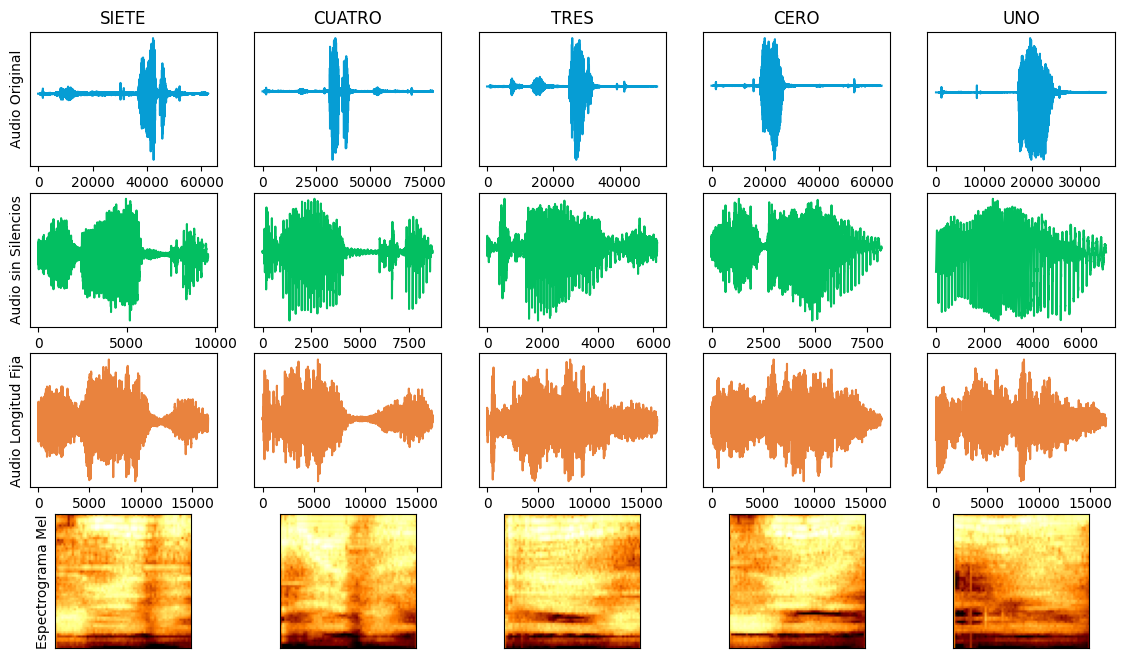

In [9]:
GRAF_CNT = 5
fig, axs = plt.subplots(4, GRAF_CNT, figsize=(14,8))

for i in range(GRAF_CNT):

    archivo = archivos[i]
    palabra = extraer_nombre_archivo(archivo)
    # carga archivo, retorna audio y frecuencia de muestreo
    audio, muestreo = librosa.load(archivo)

    #axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[0,i].plot(audio, color="#069DD4")
    axs[0,i].set_title(palabra)
    if i==0:
        axs[0,i].set_ylabel("Audio Original")

    # recorta  "silencios" antes y despues del audio. Esto es porque los silencios
    # coinciden al comparar 2 audios, algo  que se debe evitar para mejorar la efectividad
    #audio_sin_silencios = audio.recortar_silencios(audio, muestreo, AUDIO_VALIDO_SEGS)
    audio_sin_silencios = ta.recortar_silencios(audio)

    #axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[1,i].plot(audio_sin_silencios, color="#03BF61")
    if i==0:
        axs[1,i].set_ylabel("Audio sin Silencios")

    # ajusta longitud del audio para que coincida con TIEMPO_AUDIO (achica o agranda).
    # El ajuste lo hace sin perder el tono
    audio_ajustado= ta.ajustar_largo_audio(audio_sin_silencios, muestreo, TIEMPO_AUDIO)
    #axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])
    axs[2,i].plot(audio_ajustado, color="#E9833E")
    if i==0:
        axs[2,i].set_ylabel("Audio Longitud Fija")

    espectrograma_mel = ta.audio_a_espectrograma_mel(audio_ajustado, muestreo, FILTROS_MEL)
    axs[3,i].set_xticks([])
    axs[3,i].set_yticks([])
    axs[3,i].imshow(espectrograma_mel, cmap='afmhot')
    if i==0:
        axs[3,i].set_ylabel("Espectrograma Mel")